# Imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#---------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
#---------------------------------------
import tensorflow as tf

from tf_keras.src.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
#---------------------------------------
import warnings


warnings.filterwarnings("ignore")

# Loading and preprocessing

In [2]:
def train_df(tr_path):
    classes = []
    class_paths = []
    files = os.listdir(tr_path)
    for file in files:
        label_dir = os.path.join(tr_path, file)
        label = os.listdir(label_dir)
        for image in label:
            image_path = os.path.join(label_dir, image)
            class_paths.append(image_path)
            classes.append(file)
    image_classes = pd.Series(classes, name='Class')
    image_paths = pd.Series(class_paths, name='Class Path')
    tr_df = pd.concat([image_paths, image_classes], axis=1)
    return tr_df

In [3]:
def test_df(ts_path):
    classes = []
    class_paths = []
    files = os.listdir(ts_path)
    for file in files:
        label_dir = os.path.join(ts_path, file)
        label = os.listdir(label_dir)
        for image in label:
            image_path = os.path.join(label_dir, image)
            class_paths.append(image_path)
            classes.append(file)
    image_classes = pd.Series(classes, name='Class')
    image_paths = pd.Series(class_paths, name='Class Path')
    ts_df = pd.concat([image_paths, image_classes], axis=1)
    return ts_df

In [4]:
tr_df = train_df('coffee_dataset/train')
tr_df.head()

,Class Path,Class
0,coffee_dataset/train\Dark\dark (1).png,Dark
1,coffee_dataset/train\Dark\dark (10).png,Dark
2,coffee_dataset/train\Dark\dark (100).png,Dark
3,coffee_dataset/train\Dark\dark (101).png,Dark
4,coffee_dataset/train\Dark\dark (102).png,Dark


In [5]:
ts_df = test_df('coffee_dataset/test')
ts_df.head()

,Class Path,Class
0,coffee_dataset/test\Dark\dark (1).png,Dark
1,coffee_dataset/test\Dark\dark (10).png,Dark
2,coffee_dataset/test\Dark\dark (100).png,Dark
3,coffee_dataset/test\Dark\dark (11).png,Dark
4,coffee_dataset/test\Dark\dark (12).png,Dark


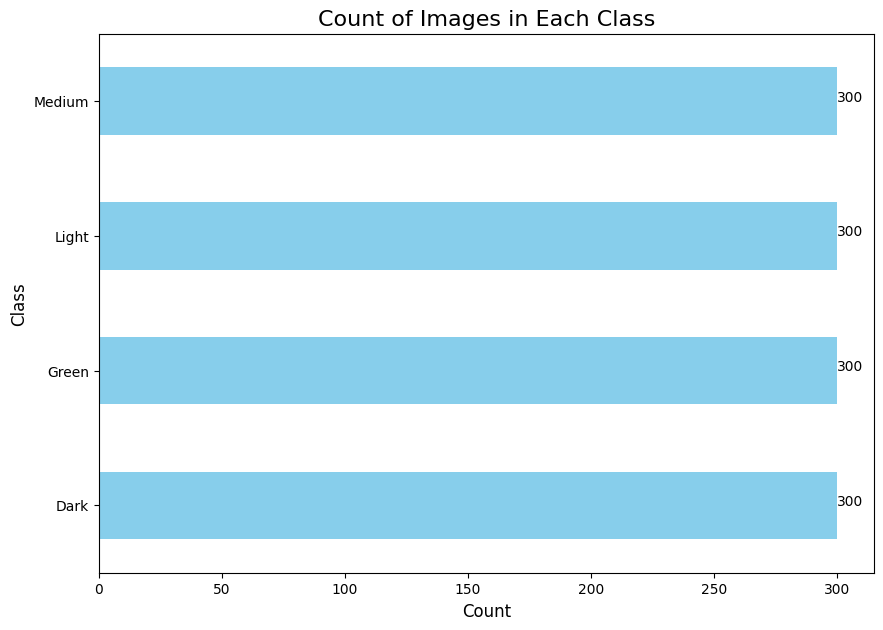

In [6]:
plt.figure(figsize=(10,7))
class_counts = tr_df['Class'].value_counts()

# Plotting the count of images in each class using column bars
class_counts.plot(kind='barh', color='skyblue')

plt.xlabel('Count', fontsize=12)
plt.ylabel('Class', fontsize=12)
plt.title('Count of Images in Each Class', fontsize=16)

# Adding labels to the bars
for index, value in enumerate(class_counts):
    plt.text(value, index, str(value))

plt.show()

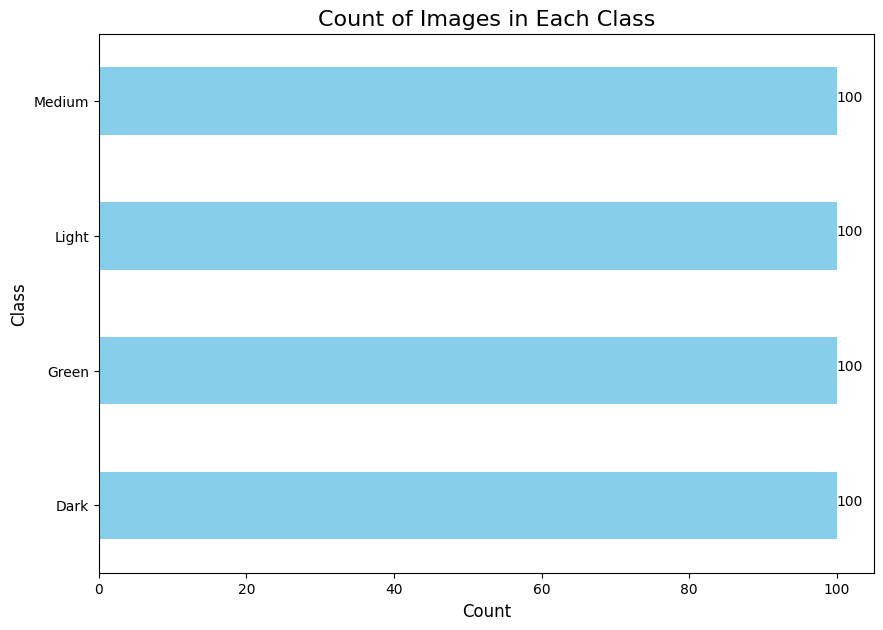

In [7]:
plt.figure(figsize=(10,7))
class_counts = ts_df['Class'].value_counts()

# Plotting the count of images in each class using column bars
class_counts.plot(kind='barh', color='skyblue')

plt.xlabel('Count', fontsize=12)
plt.ylabel('Class', fontsize=12)
plt.title('Count of Images in Each Class', fontsize=16)

# Adding labels to the bars
for index, value in enumerate(class_counts):
    plt.text(value, index, str(value))

plt.show()

In [8]:
# splitting to validation and train dataset
valid_df, ts_df = train_test_split(ts_df, train_size=.5, random_state=20)
ts_df.head()

,Class Path,Class
10,coffee_dataset/test\Dark\dark (18).png,Dark
382,coffee_dataset/test\Medium\medium (83).png,Medium
374,coffee_dataset/test\Medium\medium (76).png,Medium
196,coffee_dataset/test\Green\green (96).png,Green
47,coffee_dataset/test\Dark\dark (51).png,Dark


In [ ]:
batch_size = 16
img_size = (224,224)

train_gen = ImageDataGenerator(brightness_range=(.8, 1.2))

gen = ImageDataGenerator()

train_gen = train_gen.flow_from_dataframe(tr_df, x_col='Class Path',
                                          y_col='Class', batch_size=batch_size,
                                          target_size=img_size)

validation_gen = gen.flow_from_dataframe(valid_df, x_col='Class Path',
                                         y_col='Class', batch_size=batch_size,
                                         target_size=img_size)

test_gen = gen.flow_from_dataframe(ts_df, x_col='Class Path',
                                   y_col='Class', batch_size=batch_size,
                                   target_size=img_size, shuffle=False)

In [10]:
class_dict = train_gen.class_indices
classes = list(class_dict.keys())
images, labels = next(validation_gen)

plt.figure(figsize=(20, 20))

for i in range(16):
    plt.subplot(4, 4, i+1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name, color='k', fontsize=20)
    plt.grid(False)  # Remove grid
    
plt.show()

UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x000002589C4887C0>

# Training

In [ ]:
img_shape = (224, 224, 3)
num_classes = len(classes)

# Define the base model
base_model = tf.keras.applications.Xception(include_top=False, weights="imagenet",
                                             input_shape=img_shape, pooling='max')

# Build your model
model = Sequential([
    base_model,
    Flatten(),
    Dropout(rate=0.3),
    Dense(128, activation='relu'),
    Dropout(rate=0.25),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(Adamax(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Display model summary
model.build((None, *img_shape))
model.summary()

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
# Training
es = EarlyStopping(monitor='val_loss', mode='min',patience=3)
hist = model.fit(train_gen,
                 epochs=3,
                 validation_data=validation_gen,
                 shuffle= False,
                 callbacks=es)

# Testing

In [ ]:
model.evaluate(test_gen, verbose=1)

In [ ]:
# Save model to file
model.save("coffee_Model.h5")

# Metrics

In [ ]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
pred = model.predict(test_gen)
pred = np.argmax(pred, axis=1)

labels = train_gen.class_indices
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]

In [ ]:
y_test = ts_df['Class']
print(classification_report(y_test, pred2))
print("Accuracy of the Model:","{:.1f}%".format(accuracy_score(y_test, pred2)*100))